In [1]:
import torch
import os
import os.path as osp
import torchvision as tv
from glob import glob
from detectron2.data import transforms as T
from torchvision.transforms import functional as tvF
torch.set_grad_enabled(False)
to_pil = tv.transforms.functional.to_pil_image
from collections import defaultdict
from tqdm import tqdm
import torchvision.ops as ops
import torch.nn.functional as F
RGB = tv.io.ImageReadMode.RGB

pixel_mean = torch.Tensor([123.675, 116.280, 103.530]).view(3, 1, 1)
pixel_std = torch.Tensor([58.395, 57.120, 57.375]).view(3, 1, 1)
normalize_image = lambda x: (x - pixel_mean) / pixel_std

def iround(x): return int(round(x))

def resize_to_closest_14x(img):
    h, w = img.shape[1:]
    h, w = max(iround(h / 14), 1) * 14, max(iround(w / 14), 1) * 14
    return tvF.resize(img, (h, w), interpolation=tvF.InterpolationMode.BICUBIC)

root = osp.join(os.path.abspath(''), '..')

In [2]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
device = 0

Using cache found in /home/yangxiao/.cache/torch/hub/facebookresearch_dinov2_main
/home/yangxiao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/yangxiao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/yangxiao/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [3]:
resize_op = T.ResizeShortestEdge(
                short_edge_length=800,
                max_size=1333,
            )

In [7]:
# reading metas
class2images = {}
for f in glob(osp.join(root, 'datasets/ycb_images/**/*'), recursive=True):
    if osp.isfile(f) and 'mask' not in f:
        image_file = f
        class_name = osp.basename(osp.dirname(f))
        mask_file = osp.splitext(f)[0] + '.mask.png'
        if class_name not in class2images:
            class2images[class_name] = []
        class2images[class_name.strip().lower()].append((image_file, mask_file)) 

In [8]:
classes = sorted(class2images.keys())

In [9]:
classes

['apple',
 'ball',
 'banana',
 'bowl',
 'brick',
 'can',
 'cheez-it',
 'chips',
 'clamp',
 'cleanser bottle',
 'coffee jar',
 'comet pine',
 'cups',
 'drill',
 'glass',
 'lego',
 'lemon',
 'marker',
 'mini soccer',
 'mug',
 'mustard',
 'orange',
 'peach',
 'pear',
 'peg-hole',
 'pitcher',
 'plate',
 'screwdriver',
 'skillet',
 'spray bottle',
 'sugar box',
 'toy airplane box',
 'utensil',
 'wood blocks jar']

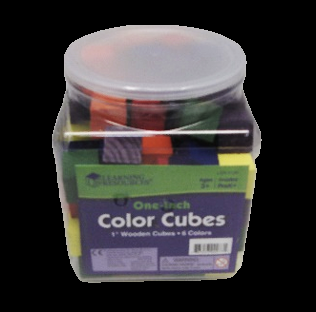

In [10]:
to_pil(tv.io.read_image(image_file, RGB) * (tv.io.read_image(mask_file) != 0).to(torch.uint8))

  0%|          | 0/34 [00:00<?, ?it/s]

/home/yangxiao/Documents/devit/demo/../datasets/ycb_images/clamp/1.jpg


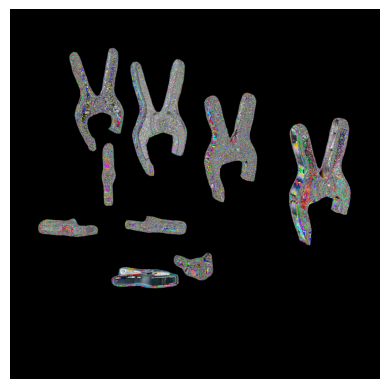

torch.Size([1024, 57, 57])
torch.Size([1, 57, 57])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
Bounding Box: [0, 6, 0, 42]


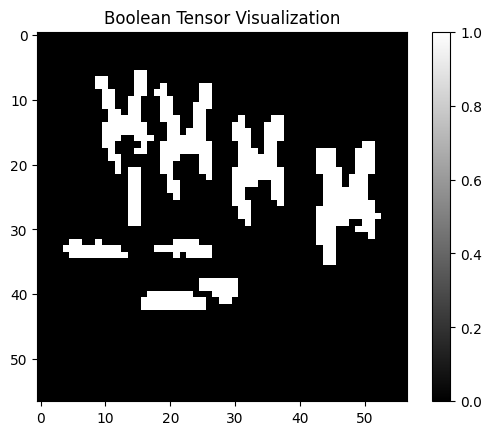

  0%|          | 0/34 [00:00<?, ?it/s]

patch_tokens2 shape:  torch.Size([3249, 1024])
mymask shape:  torch.Size([3249])
the first value of patch token2 tensor([ 0.7127, -0.6971, -0.3201,  ...,  1.1294,  0.1363, -0.9412])
tensor([[-0.2133, -0.3939, -0.1011,  ..., -0.8626,  0.9969,  1.2542],
        [-1.0042,  0.0907,  0.1132,  ...,  0.4838,  0.8250, -4.3461],
        [-0.6659,  0.5421,  0.7192,  ...,  0.6673,  0.4542, -1.3999],
        ...,
        [ 1.3858, -0.0986, -0.8148,  ...,  1.9125,  1.6833, -0.2252],
        [ 0.6725, -1.5085,  0.1274,  ...,  1.2153,  1.9347,  0.1774],
        [-0.3046, -0.7556, -0.4013,  ...,  1.9644,  1.7745,  0.8383]])
torch.Size([425, 1024])


In [40]:
model = model.to(device)
class2tokens = {}
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
def show_masked_image(image_file, mask_file):
    # Read the image and mask
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    
    
    # Convert images to numpy arrays
    image_np = np.array(image)
    mask_np = np.array(mask)
    
    # Apply the mask: Use broadcasting to apply the mask to all three channels (R, G, B)
    masked_image = image_np * mask_np[:, :, np.newaxis]
    
    # Display the masked image
    plt.imshow(masked_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()
    
for cls, images in tqdm(class2images.items()):
    class2tokens[cls] = []
    for image_file, mask_file in images:
        print(image_file)
        # cur_image = tv.io.read_image(image_file, RGB) * (tv.io.read_image(mask_file) != 0)
        # plt.imshow(cur_image.permute(1, 2, 0).numpy().astype(np.uint8))
        # plt.show()
        show_masked_image(image_file, mask_file)
        image = tv.io.read_image(image_file, RGB).permute(1, 2, 0)
        resize = resize_op.get_transform(image)
        mask = tv.io.read_image(mask_file).permute(1, 2, 0)

        mask = torch.as_tensor(resize.apply_segmentation(mask.numpy())).permute(2, 0, 1) != 0
        image = torch.as_tensor(resize.apply_image(image.numpy())).permute(2, 0, 1)

        image14 = resize_to_closest_14x(image)
        mask_h, mask_w = image14.shape[1] // 14, image14.shape[2] // 14
        nimage14 = normalize_image(image14)[None, ...]
        r = model.get_intermediate_layers(nimage14.to(device), 
                                return_class_token=True, reshape=True)   
        print(r[0][0][0].shape)
        patch_tokens = r[0][0][0].cpu()
        mask14 = tvF.resize(mask, (mask_h, mask_w))
        print(mask14.shape)
        print(mask14)
        
        # if mask14.sum() <= 0.5:
        #     continue
        # result = (mask14 * patch_tokens).flatten(1)
        # print(result)
        # print(result.shape)
        # Find the indices of True values
        true_indices = torch.where(mask14)
        
        # Compute the bounding box
        min_y, max_y = true_indices[0].min(), true_indices[0].max()
        min_x, max_x = true_indices[1].min(), true_indices[1].max()
        
        # Bounding box: [min_y, min_x, max_y, max_x]
        bounding_box = [min_y.item(), min_x.item(), max_y.item(), max_x.item()]
        
        print("Bounding Box:", bounding_box)
        # Plotting
        
        plt.imshow(mask14[0], cmap='gray')  # 'gray' colormap for binary image
        plt.colorbar()  # Optional: adds a color bar
        plt.title('Boolean Tensor Visualization')
        plt.show()
        # Example tensors
        # original_tensor = torch.rand(256, 14, 14)  # Replace with your tensor
        # boolean_tensor = torch.rand(1, 14, 14) > 0.5  # Replace with your boolean tensor
        
        # Expand the dimensions of the Boolean tensor
        # boolean_tensor_expanded = mask14.expand_as(patch_tokens)
        patch_tokens2 = patch_tokens.flatten(1).permute(1, 0)
        print("patch_tokens2 shape: ", patch_tokens2.shape)
        mymask = mask14.flatten(0)
        print("mymask shape: ", mymask.shape)
        # Element-wise multiplication
        print("the first value of patch token2", patch_tokens2[0])
        sliced_tensor = patch_tokens2[mymask]
        print(sliced_tensor)
        print(sliced_tensor.shape)
        break
        # avg_patch_token = (mask14 * patch_tokens).flatten(1).sum(1) / mask14.sum()
        # class2tokens[cls].append(avg_patch_token) 
    break

In [23]:
for cls in class2tokens:
    class2tokens[cls] = torch.stack(class2tokens[cls]).mean(dim=0)

In [24]:
prototypes = F.normalize(torch.stack([class2tokens[c] for c in classes]), dim=1)

In [25]:
category_dict = {
    'prototypes': prototypes,
    'label_names': classes
}

In [29]:
torch.save(category_dict, 'ycb_prototypes.pth')

In [27]:
prototypes.shape

torch.Size([34, 1024])

In [28]:
category_dict['label_names']

['apple',
 'ball',
 'banana',
 'bowl',
 'brick',
 'can',
 'cheez-it',
 'chips',
 'clamp',
 'cleanser bottle',
 'coffee jar',
 'comet pine',
 'cups',
 'drill',
 'glass',
 'lego',
 'lemon',
 'marker',
 'mini soccer',
 'mug',
 'mustard',
 'orange',
 'peach',
 'pear',
 'peg-hole',
 'pitcher',
 'plate',
 'screwdriver',
 'skillet',
 'spray bottle',
 'sugar box',
 'toy airplane box',
 'utensil',
 'wood blocks jar']

In [26]:
from tqdm import trange
from d2s_dataset_util import *
from pycocotools.coco import COCO
json_path = "./d2s/annotations/D2S_training.json"
# load coco format data
coco = COCO(annotation_file=json_path)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [29]:
# get all class labels
coco_classes = dict([(v['id'], v['name']) for k,v in coco.cats.items()])

In [30]:
list(coco_classes.values())

['gepa_bio_und_fair_fencheltee',
 'gepa_bio_und_fair_kraeuterteemischung',
 'gepa_bio_und_fair_kamillentee',
 'ethiquable_gruener_tee_ceylon',
 'gepa_bio_und_fair_pfefferminztee',
 'gepa_bio_und_fair_rooibostee',
 'kilimanjaro_tea_earl_grey',
 'koelln_muesli_fruechte',
 'koelln_muesli_schoko',
 'dr_oetker_vitalis_knuspermuesli_klassisch',
 'corny_nussvoll',
 'corny_schoko_banane',
 'pelikan_tintenpatrone_canon',
 'lettuce',
 'carrot',
 'cucumber',
 'zucchini',
 'apple_golden_delicious',
 'apple_granny_smith',
 'apple_red_boskoop',
 'orange_single',
 'clementine_single',
 'avocado',
 'banana_bundle',
 'banana_single',
 'kiwi',
 'pear',
 'franken_tafelreiniger',
 'suntory_gokuri_lemonade',
 'pasta_reggia_elicoidali',
 'pasta_reggia_fusilli',
 'pasta_reggia_spaghetti',
 'caona_cocoa',
 'cafe_wunderbar_espresso',
 'gepa_italienischer_bio_espresso',
 'douwe_egberts_professional_ground_coffee',
 'corny_nussvoll_single',
 'corny_schoko_banane_single',
 'gepa_bio_caffe_crema',
 'cocoba_cocoa',

In [31]:
len(coco_classes)

60

In [62]:


object_bank = {}
for i in range(1, 61):
    imgIds = cat_to_images(coco, [i])
    cur_len = len(imgIds)
    # hard code the sample idx
    # will change later
    # cur_idx = [j for j in range(0, cur_len, cur_len//5)] # cur_len//5
    cur_idx = [j for j in range(0, cur_len)] # min(cur_len, 10)
    sample_imgIds = [imgIds[i] for i in cur_idx]
    # sample_imgIds = imgIds
    object_bank[i] = sample_imgIds

In [63]:
object_bank

{1: [33201,
  33202,
  33203,
  33204,
  33205,
  33206,
  33207,
  8100,
  8101,
  8102,
  8103,
  8104,
  8105,
  8106,
  8107,
  8108,
  8109,
  8110,
  8111,
  8112,
  8113,
  8114,
  8115,
  8116,
  8117,
  8118,
  8119,
  8120,
  8121,
  8122,
  8123,
  8124,
  8125,
  8126,
  8127,
  8128,
  8129,
  33209,
  33210,
  33211,
  33212,
  33213,
  33214,
  33215,
  33216,
  33217,
  33218,
  33219,
  33220,
  33221,
  33222,
  33223,
  33224,
  33225,
  33226,
  33227,
  33228,
  33229,
  33208,
  33200],
 2: [33106,
  33107,
  33109,
  33111,
  33112,
  33113,
  33114,
  33115,
  33116,
  8000,
  8001,
  8002,
  8003,
  8004,
  8005,
  8006,
  8007,
  8008,
  8009,
  8010,
  8011,
  33100,
  33101,
  33102,
  33103,
  33104,
  33105,
  8012,
  8013,
  33108,
  8014,
  33110,
  8015,
  8016,
  8017,
  8018,
  8019,
  8020,
  8021,
  8022,
  8023,
  8024,
  8025,
  8026,
  8027,
  8028,
  8029,
  33117,
  33118,
  33119,
  33120,
  33121,
  33122,
  33123,
  33124,
  33125,
  33126,


In [64]:
sup_imgs, sup_masks = catID_to_support_set_each_object(coco, 1, object_bank)

In [65]:
sup_imgs[0].shape

(1440, 1920, 3)

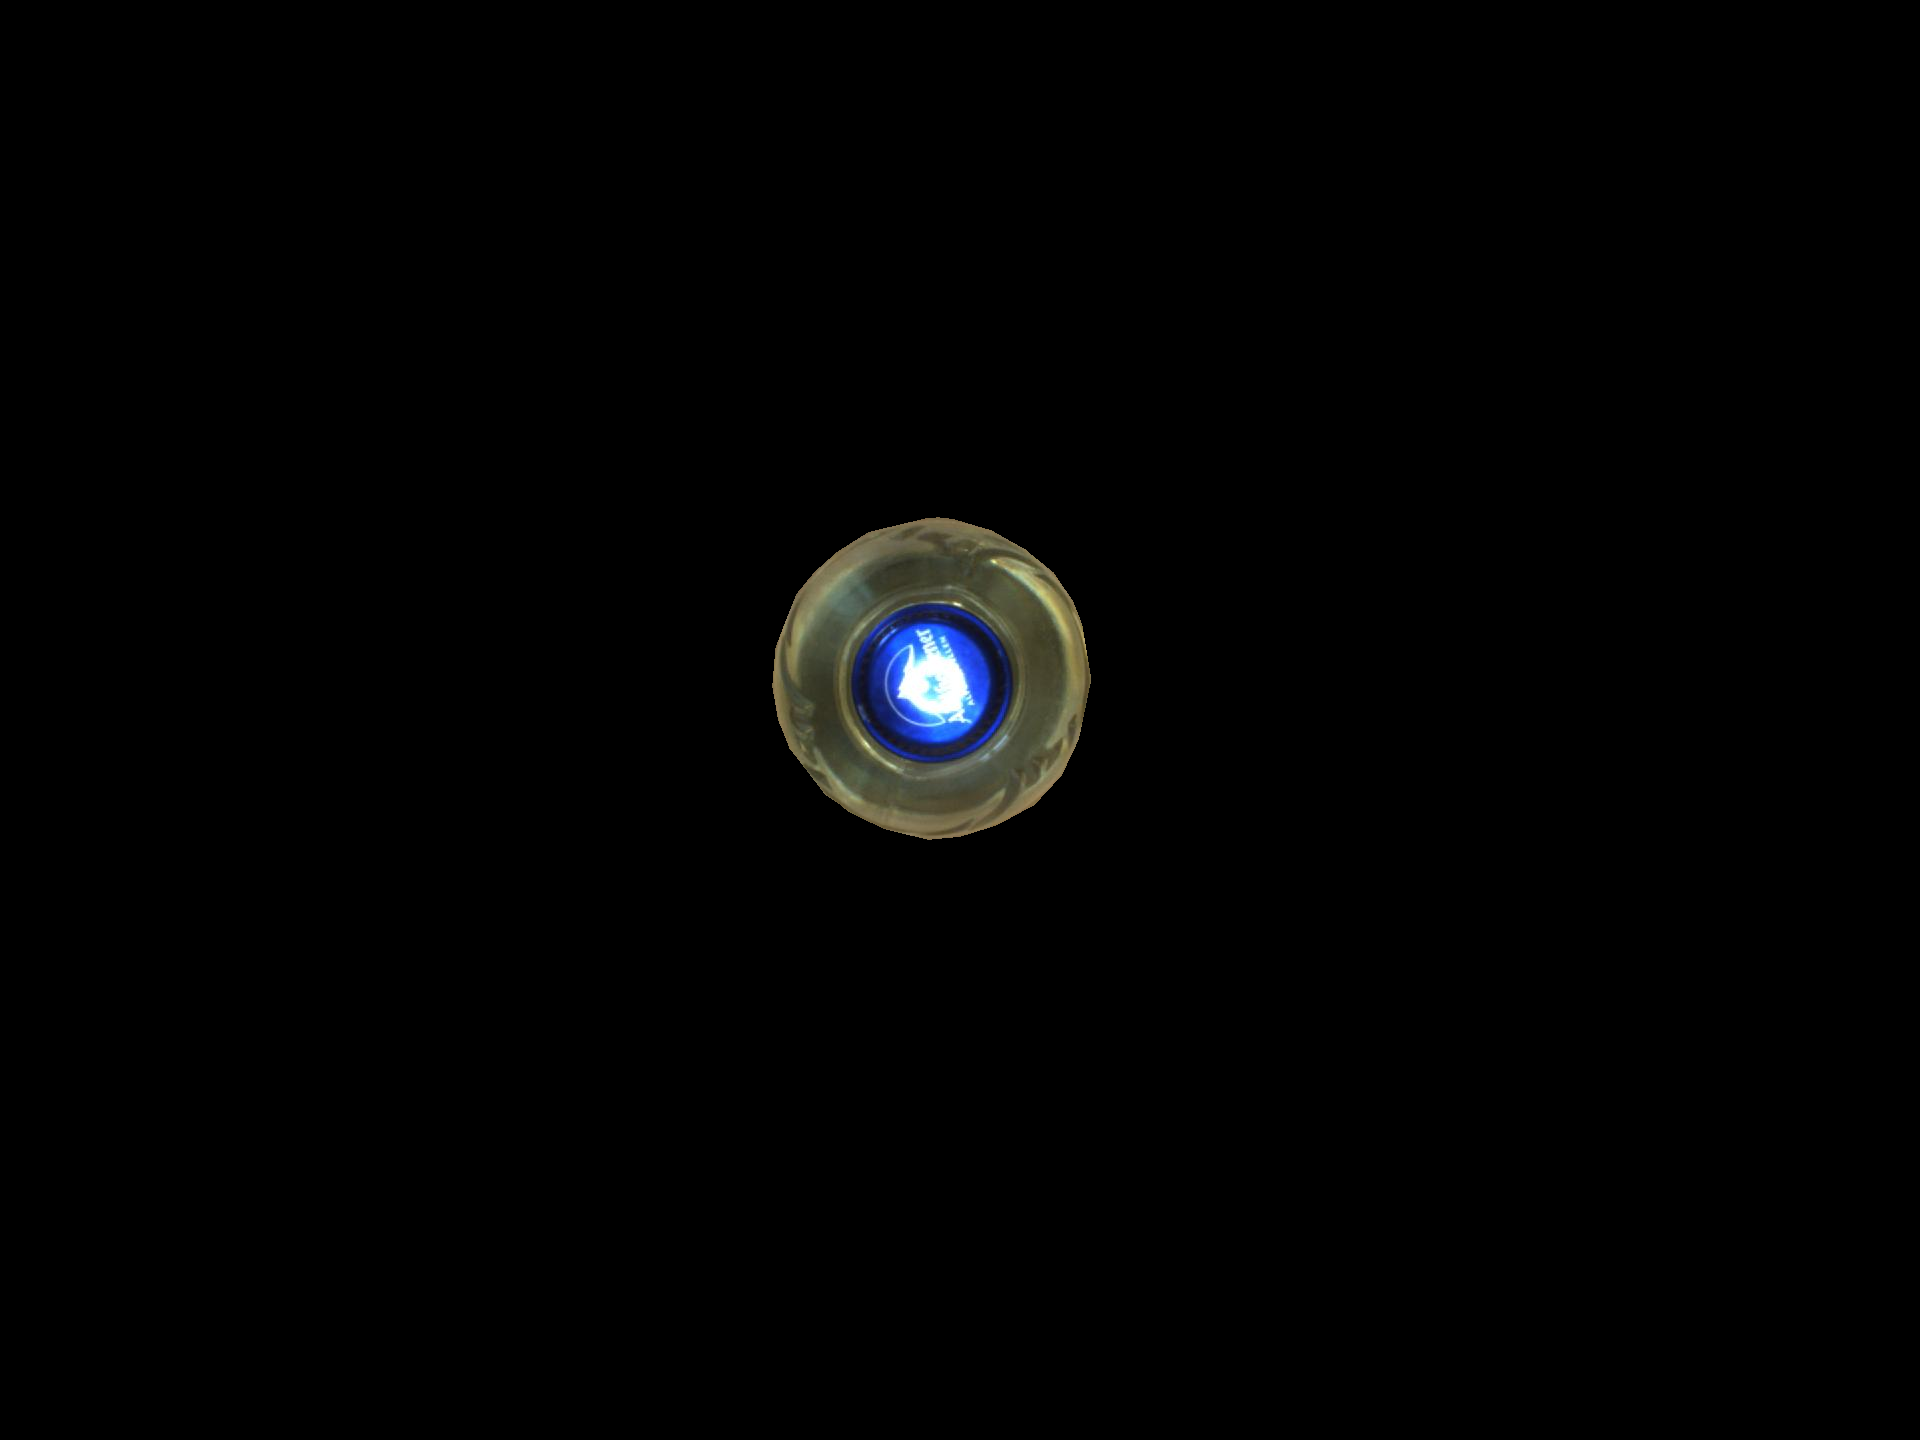

In [66]:
to_pil(sup_imgs[0].astype(np.uint8))

In [67]:
class2tokens = {}
for i in trange(1, 61):
    cls = coco_classes[i]
    class2tokens[cls] = []
    sup_imgs, sup_masks = catID_to_support_set_each_object(coco, i, object_bank)
    for image, mask in zip(sup_imgs, sup_masks):    
        image = image.astype(np.uint8)
        mask = mask.astype(np.uint8)
        # Converting to 3D array with shape (H, W, 1)
        mask = np.expand_dims(mask, axis=-1)
        resize = resize_op.get_transform(image)
        
        mask = torch.as_tensor(resize.apply_segmentation(mask)).permute(2, 0, 1) != 0
        image = torch.as_tensor(resize.apply_image(image)).permute(2, 0, 1)
        
        image14 = resize_to_closest_14x(image)
        mask_h, mask_w = image14.shape[1] // 14, image14.shape[2] // 14
        nimage14 = normalize_image(image14)[None, ...]
        r = model.get_intermediate_layers(nimage14.to(device), 
                                return_class_token=True, reshape=True)    
        patch_tokens = r[0][0][0].cpu()
        mask14 = tvF.resize(mask, (mask_h, mask_w))
        if mask14.sum() <= 0.5:
            continue
        avg_patch_token = (mask14 * patch_tokens).flatten(1).sum(1) / mask14.sum()
        class2tokens[cls].append(avg_patch_token) 

100%|██████████| 60/60 [1:13:21<00:00, 73.36s/it] 


In [68]:
for cls in class2tokens:
    if len(class2tokens[cls]) == 0:
        continue
    class2tokens[cls] = torch.stack(class2tokens[cls]).mean(dim=0)

In [69]:
# for cls in class2tokens:
#     print(cls, len(class2tokens[cls]))

In [70]:
len(class2tokens)

60

In [71]:
d2s_classes = list(coco_classes.values())
prototypes = F.normalize(torch.stack([class2tokens[c] for c in d2s_classes]), dim=1)

In [72]:
category_dict = {
    'prototypes': prototypes,
    'label_names': d2s_classes
}

In [73]:
torch.save(category_dict, 'd2s_all_templates_each_object_prototypes.pth')

In [74]:
prototypes.shape

torch.Size([60, 1024])

  0%|          | 0/60 [00:00<?, ?it/s]

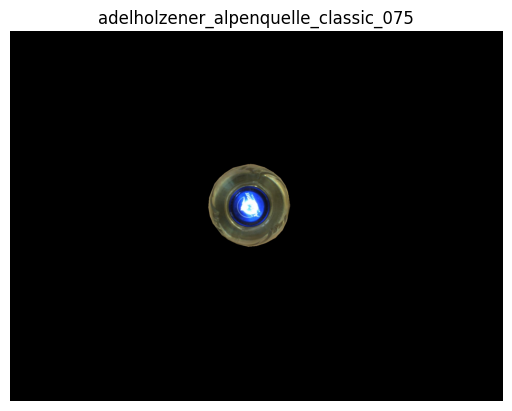

  2%|▏         | 1/60 [00:00<00:31,  1.87it/s]

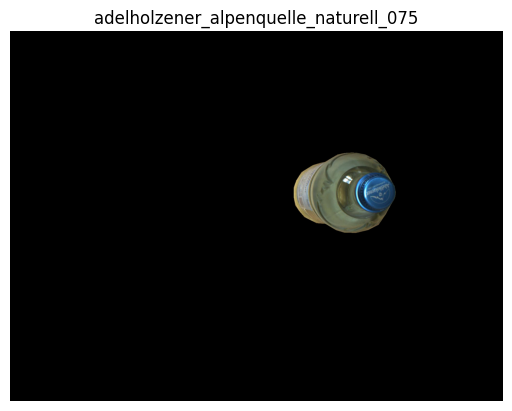

  3%|▎         | 2/60 [00:00<00:28,  2.04it/s]

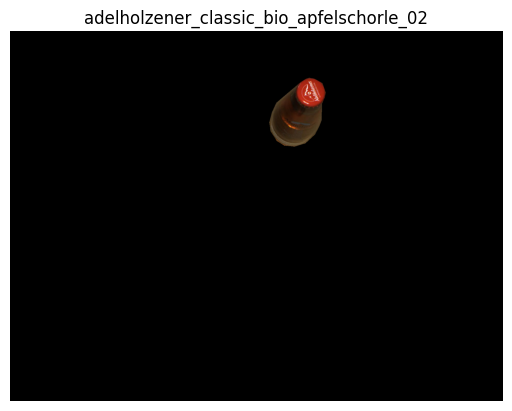

  5%|▌         | 3/60 [00:01<00:30,  1.86it/s]

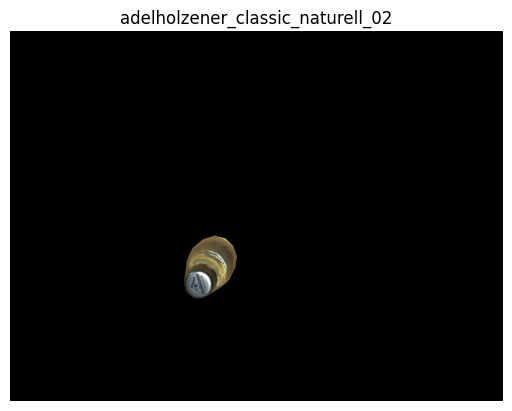

  7%|▋         | 4/60 [00:02<00:29,  1.93it/s]

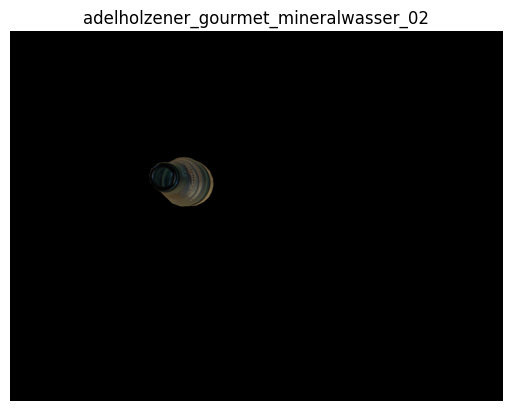

  8%|▊         | 5/60 [00:02<00:27,  1.97it/s]

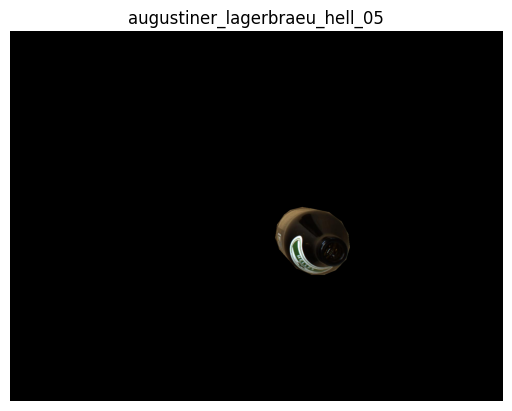

 10%|█         | 6/60 [00:03<00:30,  1.78it/s]

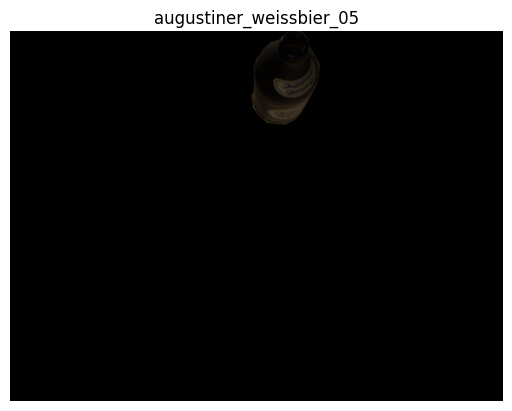

 12%|█▏        | 7/60 [00:03<00:27,  1.95it/s]

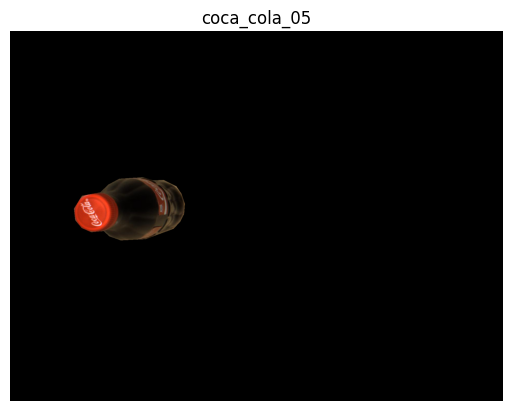

 13%|█▎        | 8/60 [00:04<00:25,  2.03it/s]

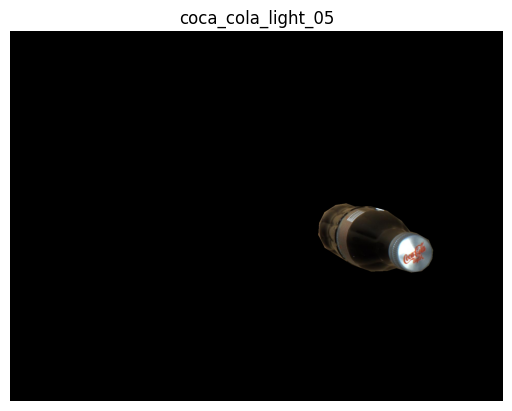

 15%|█▌        | 9/60 [00:04<00:24,  2.05it/s]

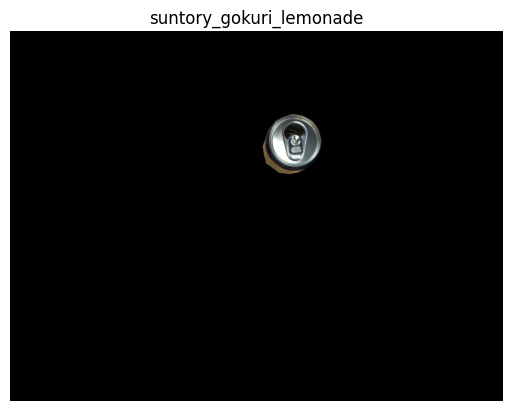

 17%|█▋        | 10/60 [00:05<00:28,  1.76it/s]

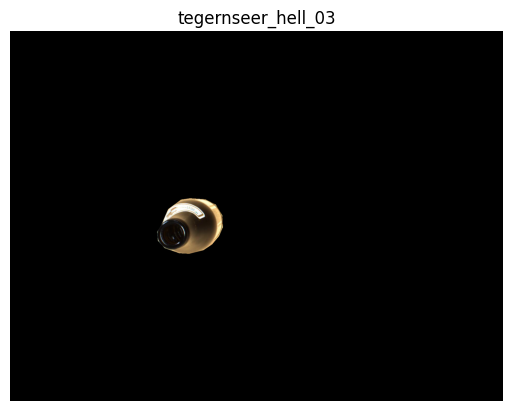

 18%|█▊        | 11/60 [00:05<00:27,  1.81it/s]

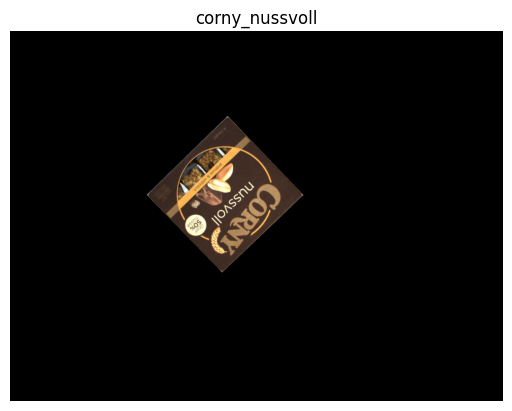

 20%|██        | 12/60 [00:06<00:24,  1.97it/s]

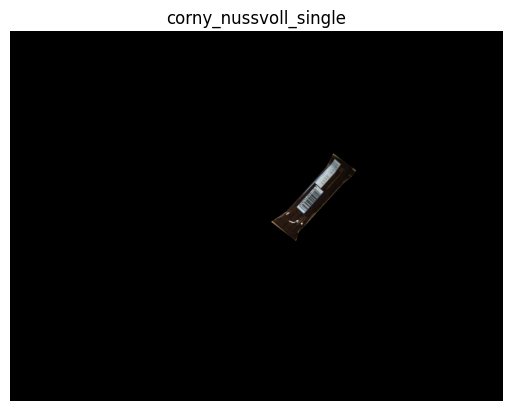

 22%|██▏       | 13/60 [00:06<00:23,  1.99it/s]

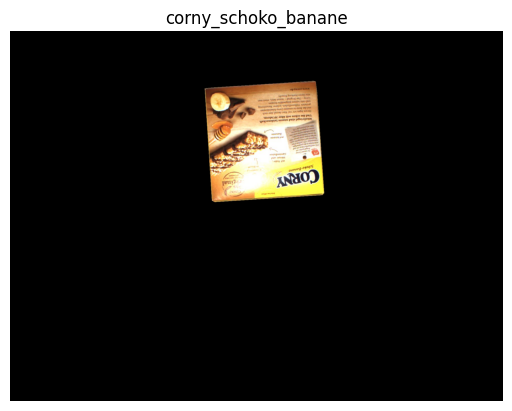

 23%|██▎       | 14/60 [00:07<00:21,  2.10it/s]

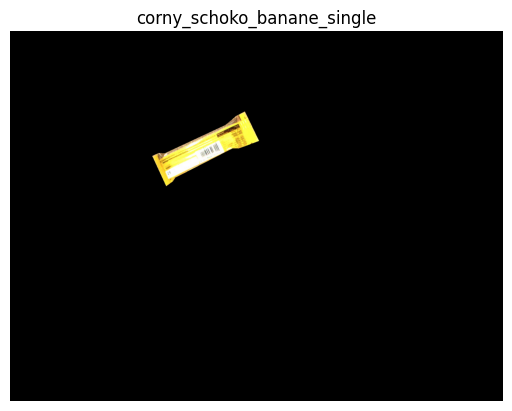

 25%|██▌       | 15/60 [00:07<00:26,  1.73it/s]

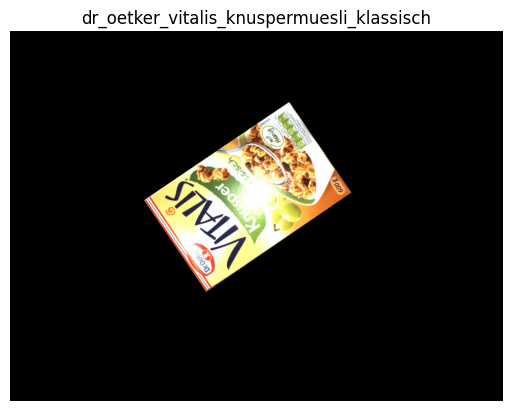

 27%|██▋       | 16/60 [00:08<00:22,  1.94it/s]

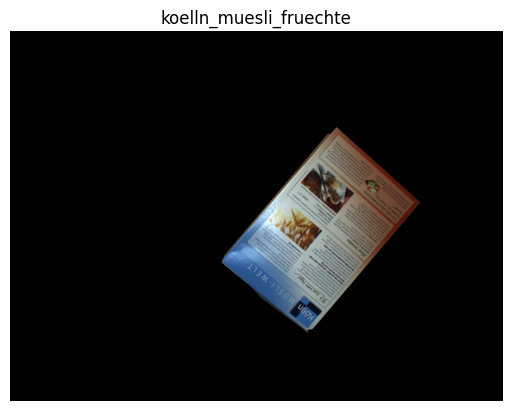

 28%|██▊       | 17/60 [00:08<00:20,  2.12it/s]

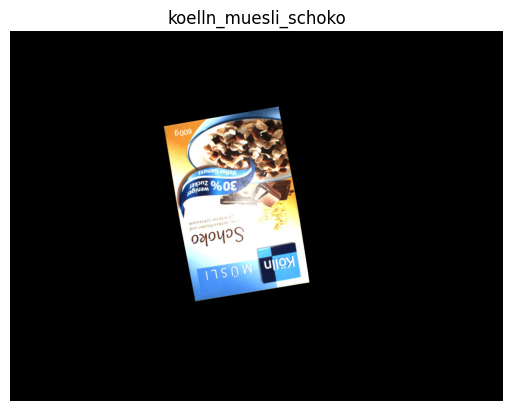

 30%|███       | 18/60 [00:09<00:19,  2.15it/s]

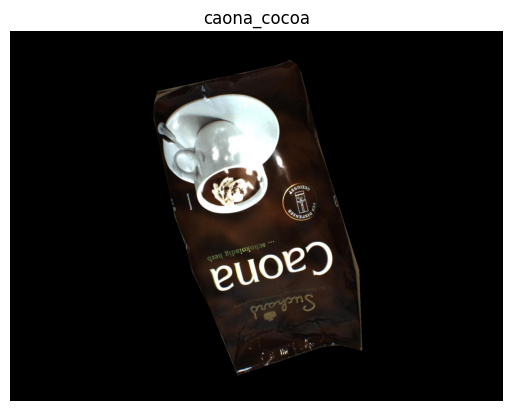

 32%|███▏      | 19/60 [00:09<00:18,  2.22it/s]

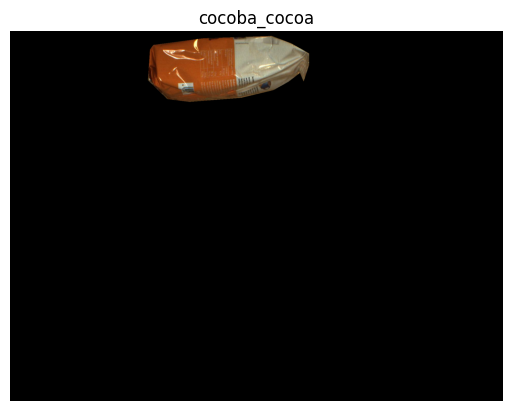

 33%|███▎      | 20/60 [00:10<00:19,  2.05it/s]

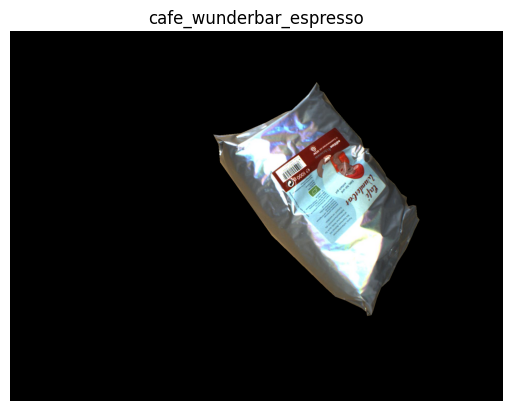

 35%|███▌      | 21/60 [00:10<00:18,  2.14it/s]

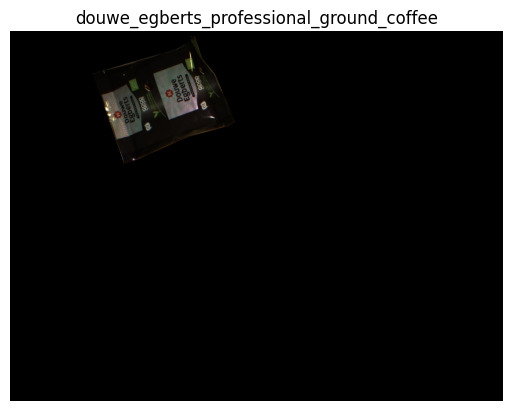

 37%|███▋      | 22/60 [00:11<00:20,  1.88it/s]

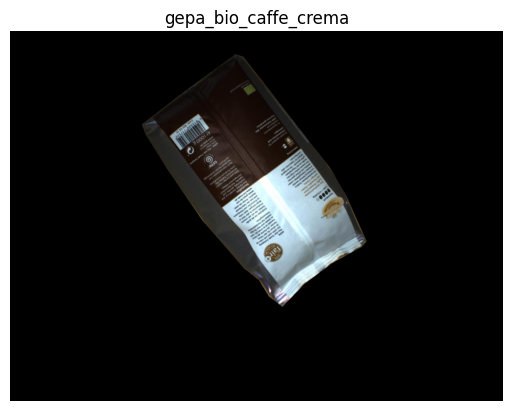

 38%|███▊      | 23/60 [00:11<00:18,  2.01it/s]

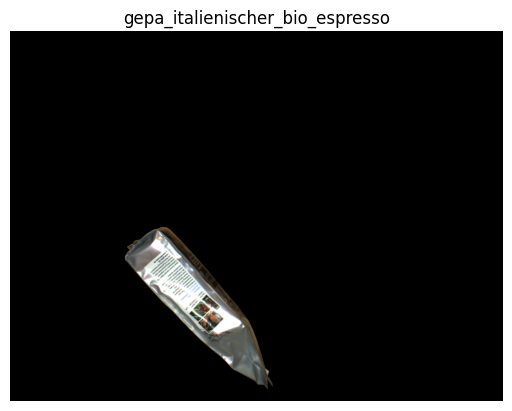

 40%|████      | 24/60 [00:12<00:19,  1.86it/s]

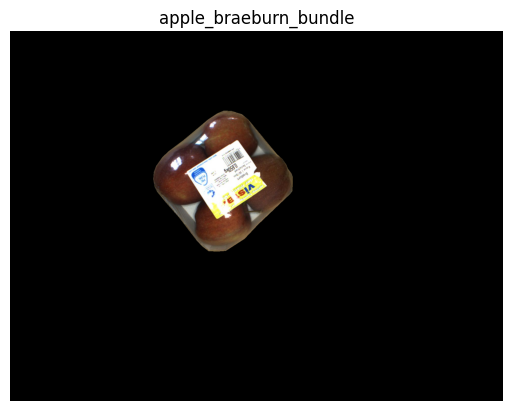

 42%|████▏     | 25/60 [00:12<00:17,  2.00it/s]

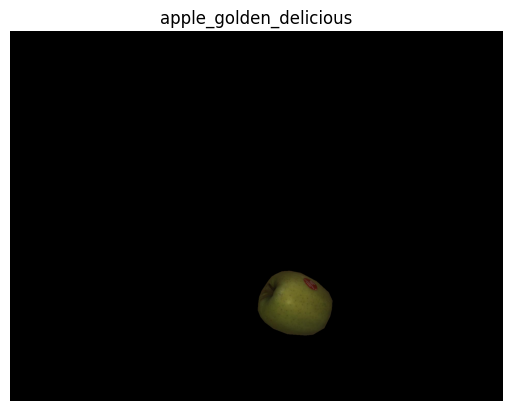

 43%|████▎     | 26/60 [00:13<00:17,  1.91it/s]

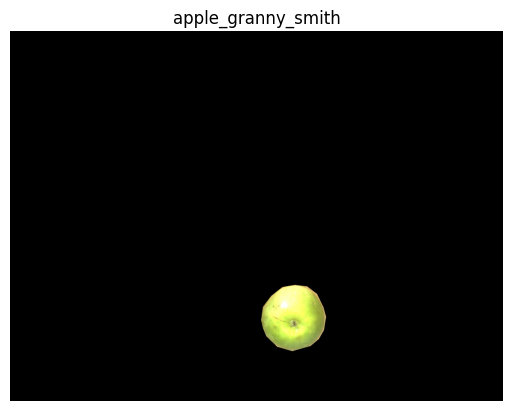

 45%|████▌     | 27/60 [00:13<00:18,  1.80it/s]

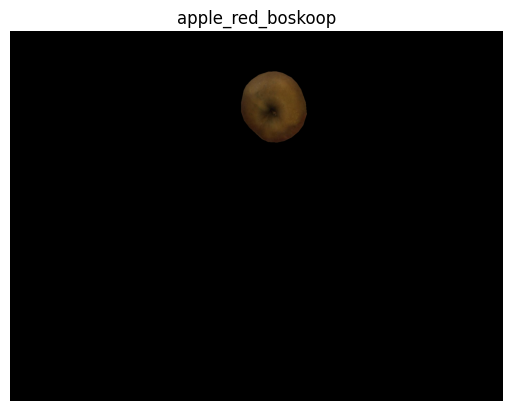

 47%|████▋     | 28/60 [00:14<00:17,  1.81it/s]

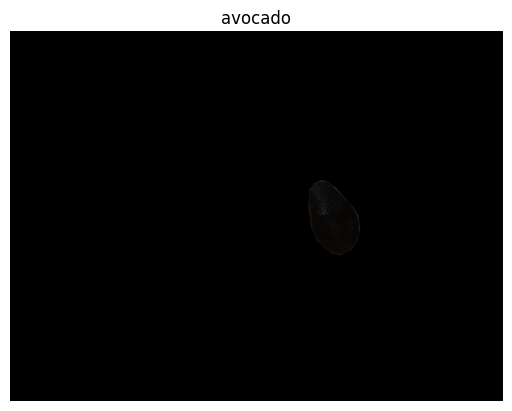

 48%|████▊     | 29/60 [00:15<00:18,  1.72it/s]

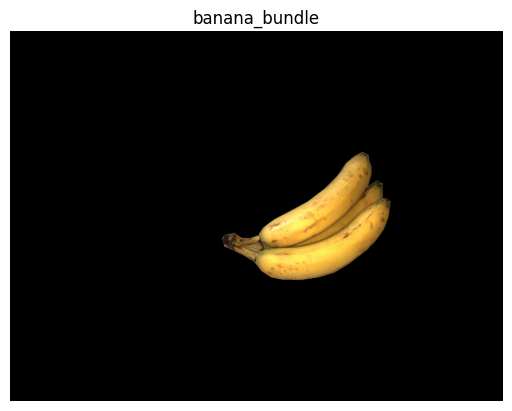

 50%|█████     | 30/60 [00:15<00:16,  1.84it/s]

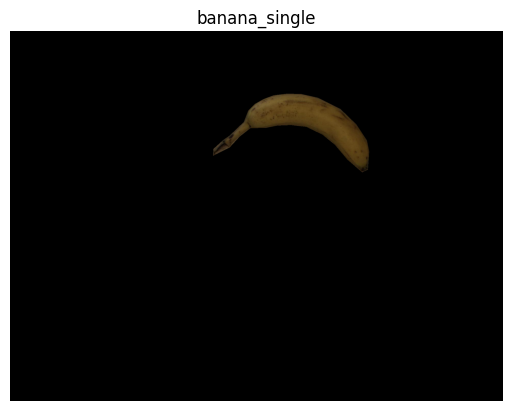

 52%|█████▏    | 31/60 [00:15<00:14,  1.98it/s]

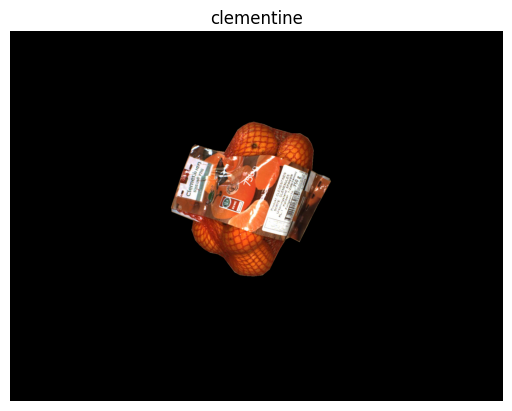

 53%|█████▎    | 32/60 [00:16<00:13,  2.10it/s]

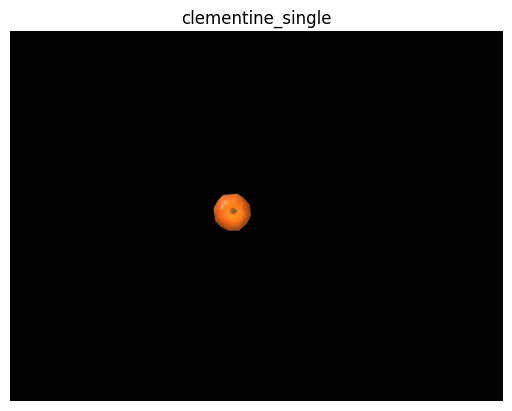

 55%|█████▌    | 33/60 [00:16<00:12,  2.19it/s]

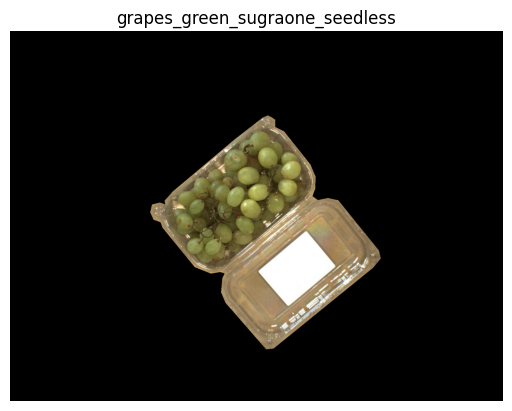

 57%|█████▋    | 34/60 [00:17<00:11,  2.25it/s]

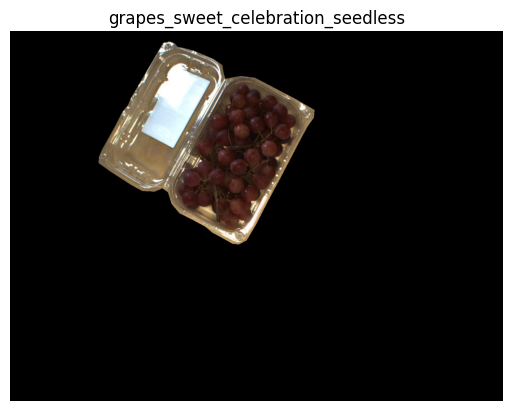

 58%|█████▊    | 35/60 [00:17<00:11,  2.18it/s]

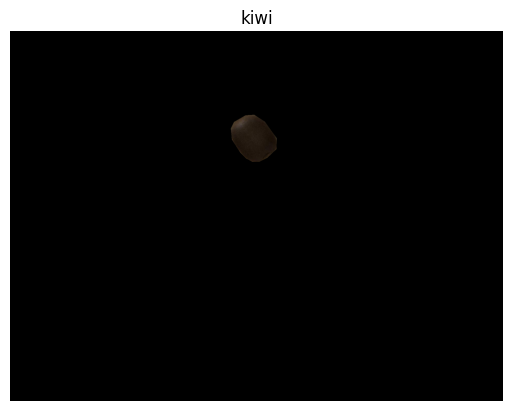

 60%|██████    | 36/60 [00:18<00:11,  2.13it/s]

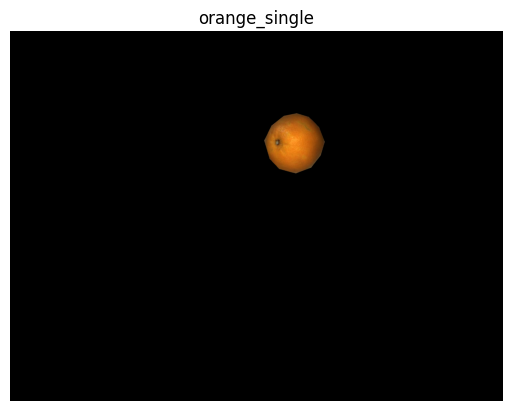

 62%|██████▏   | 37/60 [00:18<00:11,  2.03it/s]

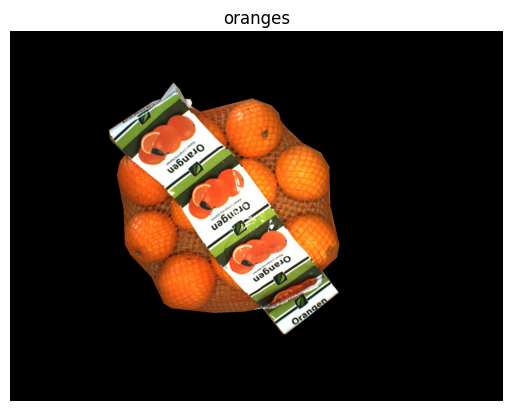

 63%|██████▎   | 38/60 [00:19<00:10,  2.18it/s]

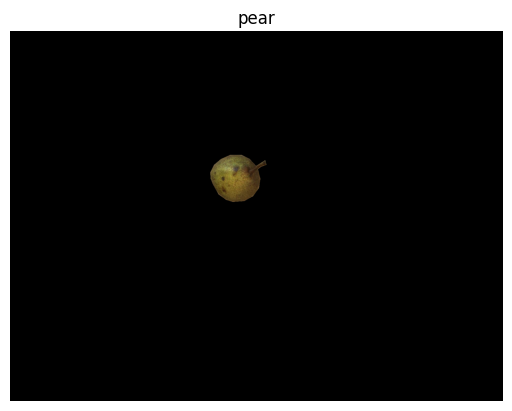

 65%|██████▌   | 39/60 [00:19<00:09,  2.22it/s]

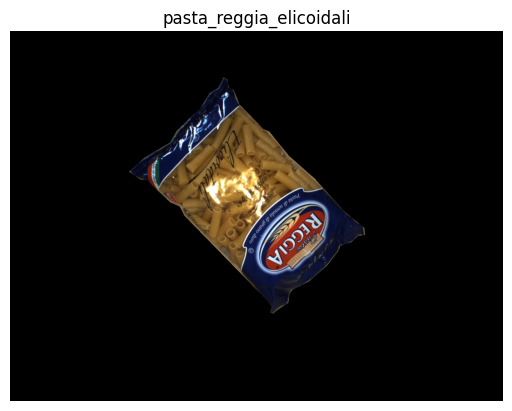

 67%|██████▋   | 40/60 [00:19<00:08,  2.34it/s]

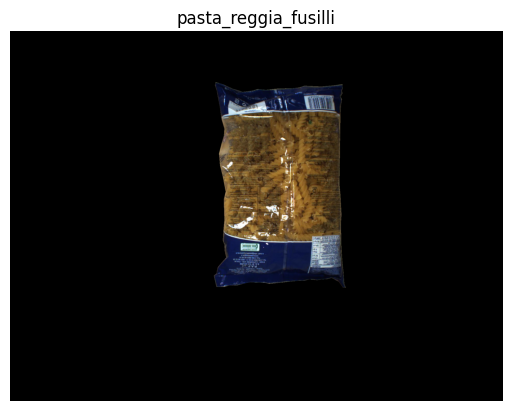

 68%|██████▊   | 41/60 [00:20<00:07,  2.44it/s]

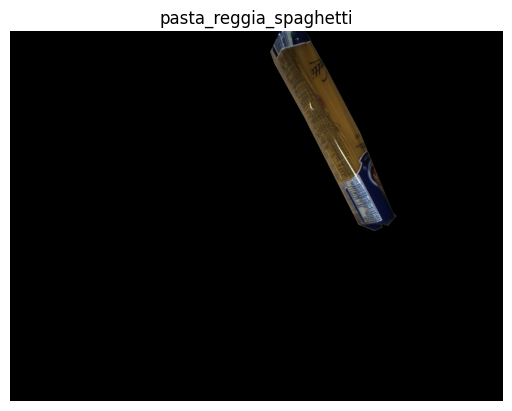

 70%|███████   | 42/60 [00:20<00:07,  2.45it/s]

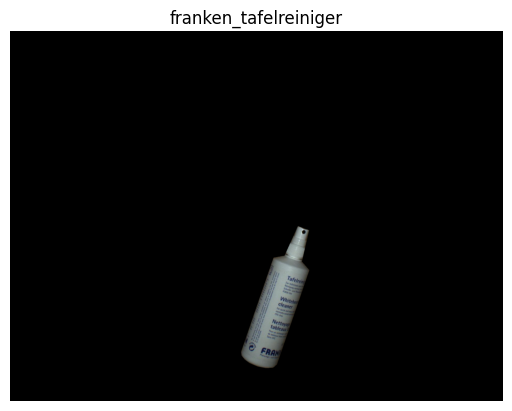

 72%|███████▏  | 43/60 [00:21<00:07,  2.26it/s]

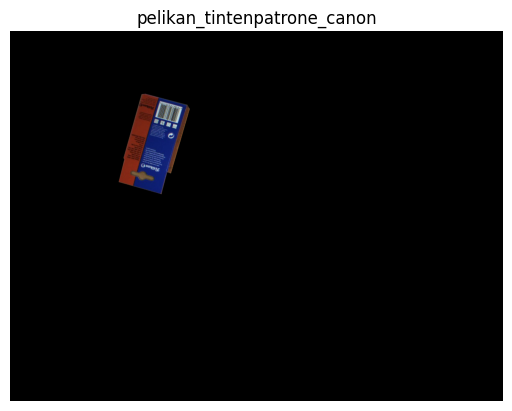

 73%|███████▎  | 44/60 [00:21<00:07,  2.15it/s]

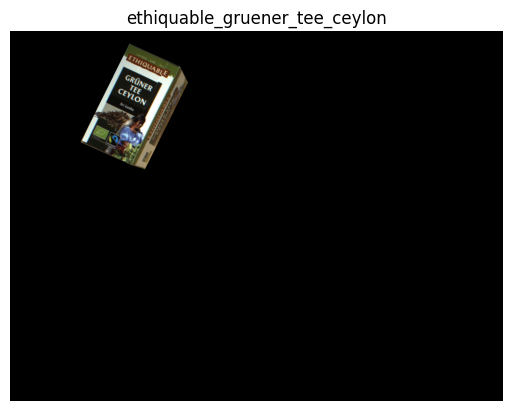

 75%|███████▌  | 45/60 [00:22<00:07,  1.90it/s]

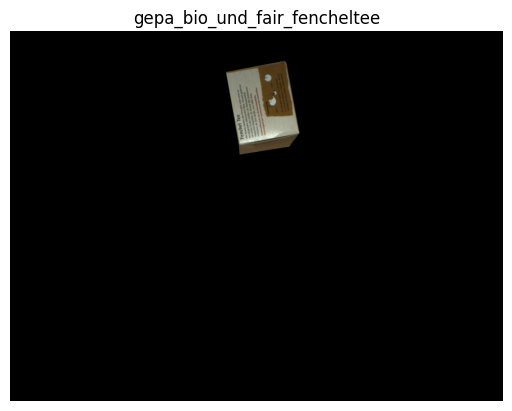

 77%|███████▋  | 46/60 [00:22<00:06,  2.03it/s]

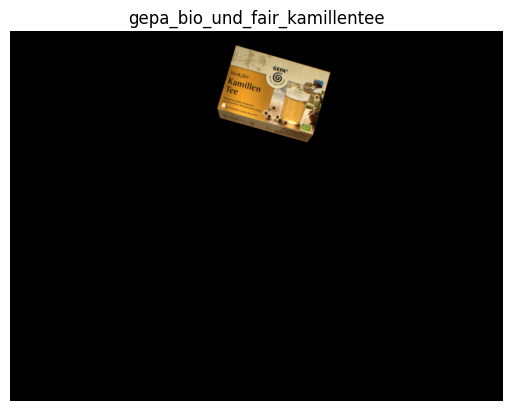

 78%|███████▊  | 47/60 [00:23<00:06,  2.13it/s]

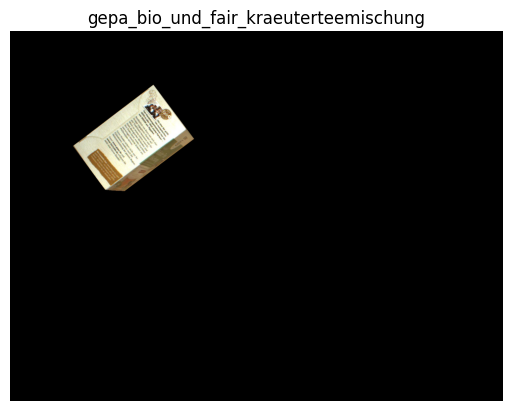

 80%|████████  | 48/60 [00:23<00:05,  2.09it/s]

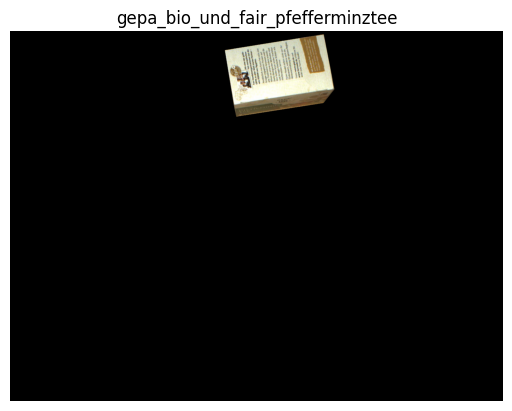

 82%|████████▏ | 49/60 [00:24<00:05,  1.99it/s]

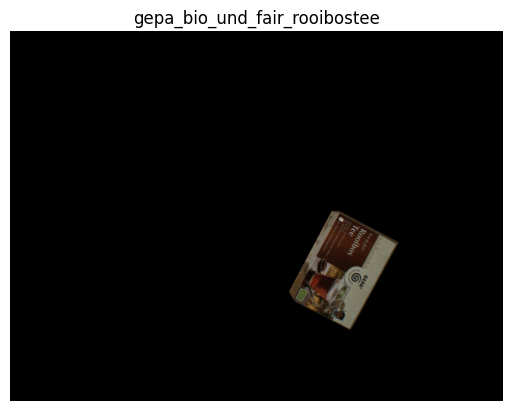

 83%|████████▎ | 50/60 [00:24<00:05,  1.79it/s]

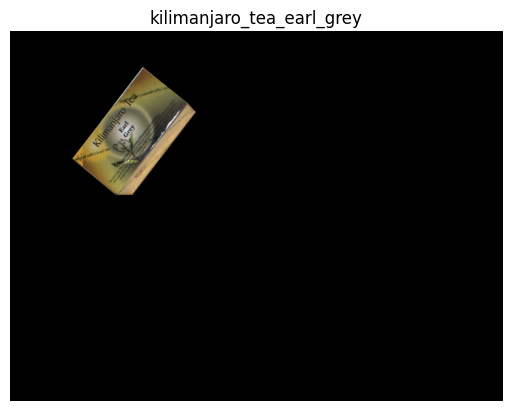

 85%|████████▌ | 51/60 [00:25<00:05,  1.69it/s]

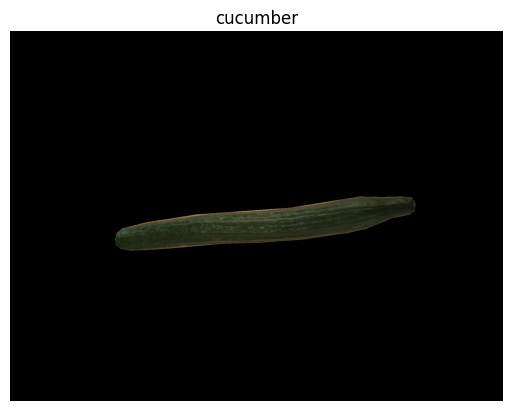

 87%|████████▋ | 52/60 [00:26<00:04,  1.86it/s]

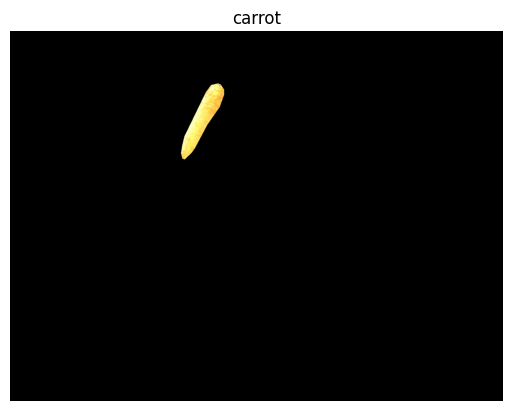

 88%|████████▊ | 53/60 [00:26<00:03,  1.80it/s]

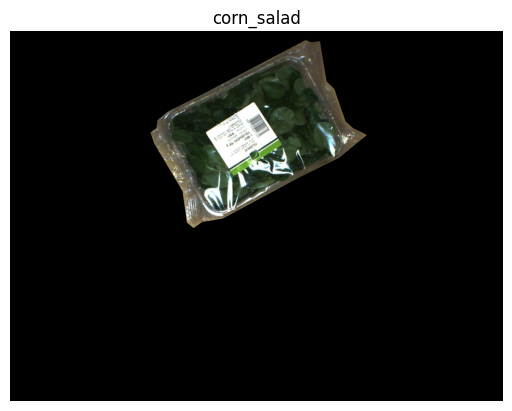

 90%|█████████ | 54/60 [00:27<00:03,  1.94it/s]

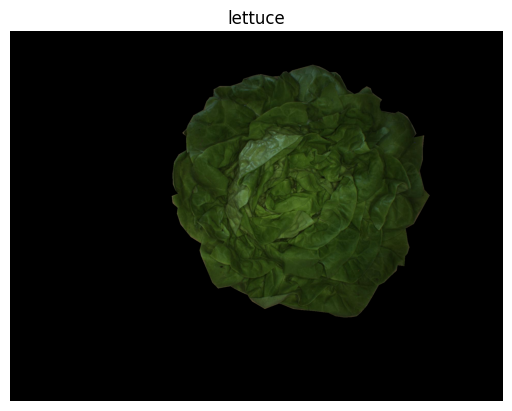

 92%|█████████▏| 55/60 [00:27<00:02,  2.03it/s]

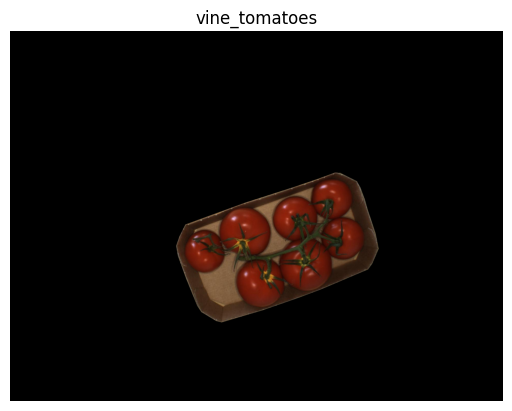

 93%|█████████▎| 56/60 [00:27<00:01,  2.06it/s]

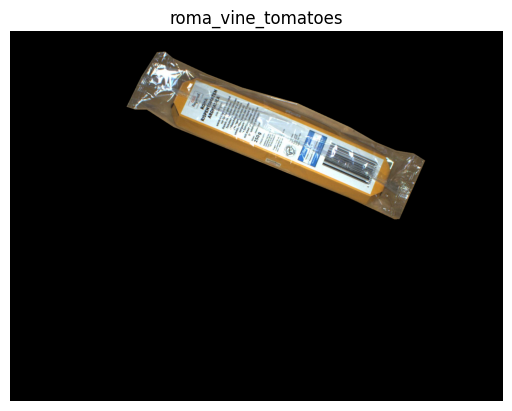

 95%|█████████▌| 57/60 [00:28<00:01,  2.15it/s]

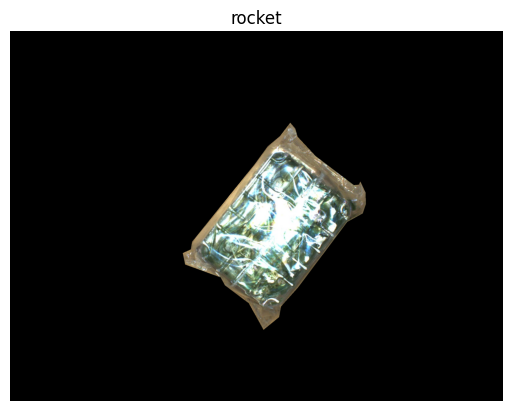

 97%|█████████▋| 58/60 [00:28<00:00,  2.20it/s]

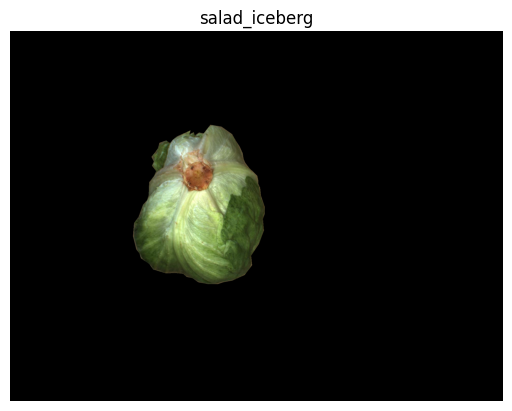

 98%|█████████▊| 59/60 [00:29<00:00,  1.90it/s]

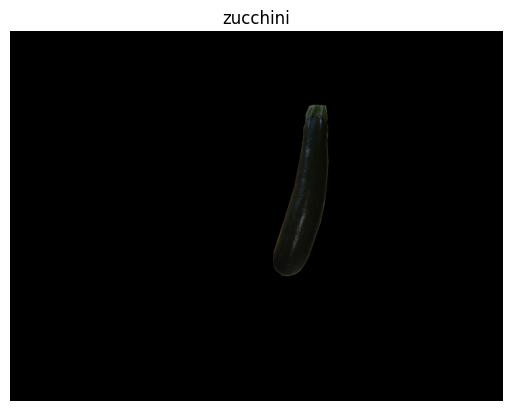

100%|██████████| 60/60 [00:30<00:00,  1.99it/s]


In [61]:
# Create a grid for subplots

for i in trange(1, 61):
    cls = coco_classes[i]
    sup_imgs, sup_masks = catID_to_support_set_each_object(coco, i, object_bank)

    plt.imshow(sup_imgs[0])
    plt.title(cls)
    plt.axis('off')  # to hide the axis
    plt.show()
